# 指标 Allocation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

In [2]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(cfg.db.perfectures)

模仿熵的公式，我们设计了一个衡量分配平均度的指标“配水指数(Water Distribution Index, WDI)”。我们假设最平均的水分配情况是，为每个行政区域某个部门分配到的用水量，都等于全流域该部门的平均用水比例。但实际上区域有别，有的区域会更集中发展某个用水部门，这就导致了水的分配不够平均，使得分配熵增大。而实际的分配情况与假设的平均分配情况，即为配水指数WDI，**WDI越大代表分配越平均，越小代表分配越不均匀**

![mW9Xbn](https://songshgeo-picgo-1302043007.cos.ap-beijing.myqcloud.com/uPic/mW9Xbn.jpg)

例如在上图中，左边展示的是假设的区域间均匀分配的情况。后者则是实际中分工各有差异，发展各有先后的情况。

我们使用 Configuration Entropy Metric $CEM$ 来表达这种配置上的均匀性

$$ CEM = \sum_{i=1}^n -log(p_{i}) * p_{i} $$

其中$i$ 代表配置水资源的单位（区域 or 部门） $p_i$ 代表了其中一个单位$i$分到水的比例。
对不同区域来说，当水资源完全平均分配，即对任意区域$i$，都有$p_i = 1/n $时，$Entropy$取最大值：

$$ CEM_{max} = \sum_{i=1}^n -log(p_{i}) * p_{i} = - log(\frac{1}{n}) $$

可见，$CEM$ 指标度量的是水资源配置“不均匀”的程度，类似于信息熵是对“混乱程度”的度量，即参与分配的各个单位之间，分配比例差距越大，则熵越小。
而我们的指标应反映随着社会发展，水资源配置在区域之间更加均衡（比例差距小）、整体满足不同用水部门的发展需求（比例差距减小）、但不同区域存在部门分工（比例差距增大）的趋势。

因此，用$CEM_r$代表流域各区域间的CEM，$CEM_s$代表流域各部门间的CEM, $CEM_{rs}$代表区域各部门间的CEM（详见附录）我们获得了表征流域用水配置的指标$I_C$：

$$ I_C = \frac{CEM_{r}*CEM_{s}}{CEM_{rs}}$$


### 配置熵指标：补充材料部分
衡量水资源配置的指标$I_C$由三部分水资源配置熵指标（CEM）构成：

$$ I_C = \frac{CEM_{r}*CEM_{s}}{CEM_{rs}}$$

(1) 描述区域间水资源配置的 $CEM_r$：

$$ CEM_r = \sum_{i=1}^4 -log(p_{i}) * p_{i} $$

其中$p_i$是区域$i$（$i=1$ to $4$ 分别代表 SR, UR, MR, or, DR）的水资源使用量（$WU_i$）在所有区域水资源消耗总量中所占的比例，即:

$$ p_i = \frac{WU_i}{\sum_{i=1}^4 WU_i} $$

(2) 描述部门间水资源配置的 $CEM_s$:

$$ CEM_s = \sum_{j=1}^3 -log(p_{j}) * p_{j} $$

其中$p_j$是用水部门$j$（$j=1$ to $3$ 分别代表 agriculture, industry, domestic and services）的水资源使用量（$WU_j$）在所有部门水资源消耗总量中所占的比例，即:

$$ p_j = \frac{WU_j}{\sum_{j=1}^3 WU_j} $$


(3) 描述区域各部门间水资源配置分工的 $CEM_{rs}$:

$$ CEM_{rs} = \frac{1}{3} * \sum_{j=1}^3 \sum_{i=1}^4 -log(p_{ij} * p_{ij})$$

其中$p_{ij}$是区域$i$在部门$j$上的用水$WU_{ij}$占所有区域在部门$j$上总用水的比例，即：

$$ p_{ij} = \frac{WU_ij}{\sum_{i=1}^4 WU_ij} $$

### 熵指标的变化区间

Text(0, 0.5, 'Allocation indicator')

Text(0.5, 0, 'Year')

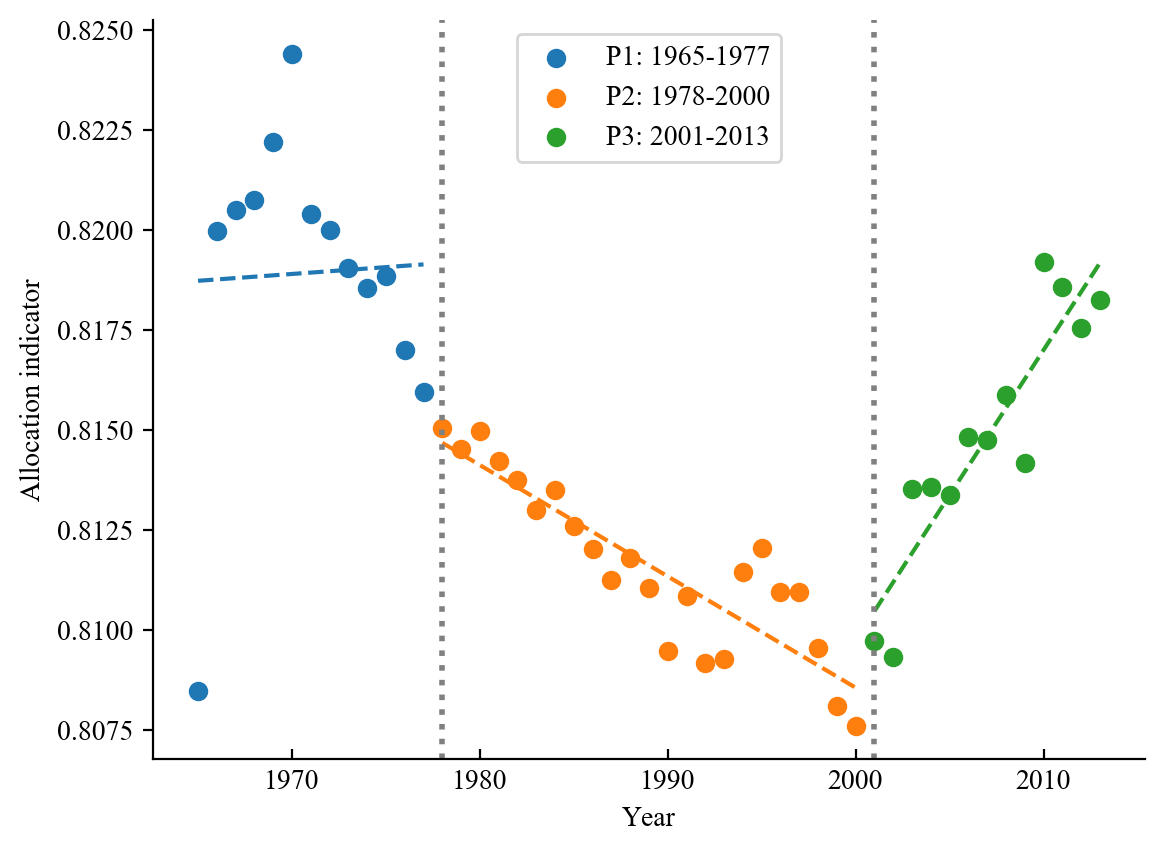

In [3]:
from regimes_yrb.allocation import calc_regional_entropy
from regimes_yrb.plot import plot_data
from regimes_yrb.tools.statistic import norm_zscore
from mksci_font import config_font
from regimes_yrb.plot import plot_pettitt_change_points
from matplotlib import pyplot as plt

config_font()
allocation = calc_regional_entropy(city_yr)

ax1 = plot_pettitt_change_points(
    allocation,
    change_points=cfg.breakpoints,
    returns="ax",
)
ax1.set_ylabel("Allocation indicator")
# ax1.set_ylabel("分配方式")
# ax1.set_xlabel("年份")
ax1.set_xlabel("Year")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

plt.savefig("figures/sup/allocation.png", dpi=300)

# 数据导出
allocation.to_csv(cfg.db.results.A)

可以发现，趋势变化的转折点发生在 1981 和 2002 年